In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython import display

In [50]:
# PID controller
class PID:
    """
    PID control, refer to https://en.wikipedia.org/wiki/PID_controller
    Need to tune the three parameters: Kp (proportioanl gain), Ki (integral gain), Kd (derivative gain), and the upper and lower bounds.
    """
    def __init__(self,
                 Kp, Ki, Kd,
                 out_hi=100, out_lo=0):
        """
        initialize the controller
        Kp: proportioanl gain
        Ki: integral gain
        Kd: derivative gain
        out_hi: output upper bound
        out_lo: output lower bound
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.out_hi = out_hi
        self.out_lo = out_lo
        self.ie = 0
        self.de = 0
        self.e_old = 0
        self.first_cycle=True
        
    def compute(self,
                setpoint, pv, delta_t,
                ):
        """
        return the PID controller output
        setpoint: set point
        pv: control point (current value)
        delta_t: sampling time in second
        
        """
        # Compute output
        e = setpoint - pv  # error
        if self.first_cycle is False:
            self.ie += e * delta_t
            self.de = (e - self.e_old) / delta_t    
        P = self.Kp * e
        I = self.Ki * self.ie
        D = self.Kd * self.de
        out = P + I + D
        
        # Apply output upper/lower bounds
        if out > self.out_hi:  # check upper bound
            out = self.out_hi
            if self.first_cycle is False:
                self.ie -= e * delta_t # anti-reset windup
        if out < self.out_lo:  # check lower bound
            out = self.out_lo
            if self.first_cycle is False:
                self.ie -= e * delta_t # anti-reset windup

        self.e_old = e
        if self.first_cycle is True:
            self.first_cycle = False
        return out

# Room temperature model (linear state-space model)
def room_model(x_0, u_OA_0, u_qint_0, u_HVAC_0):
    """
    predicts next timestep indoor temperatures with current indoor temperatures, \
    outdoor air temperature, internal heat gain rate, and delivered cooling rate.
    
    inputs
    x_0: current indoor temperatures in degC, 2x1 np array
    u_OA_0: current outdoor temperature in degC, float
    u_qint_0: current internal heat gain rate in W, float
    u_HVAC_0: current internal heat gain rate in W, float
    
    outputs
    x_1: next timestep indoor temperatures in degC, 2x1 np array
    
    """
    A = np.array([[0.94802737003209, 0.0466708151835719],
                  [0.12, 0.868]])
    B_OA = np.array([[0.00530181478433815],
                     [0.012]])
    B_qint = np.array([[0.000233354075917859],
                       [0]])
    B_HVAC = np.array([[0],
                       [0.0006]])
    
    x_1 = np.dot(A,x_0) + np.dot(B_OA,u_OA_0) + np.dot(B_qint,u_qint_0) + np.dot(B_HVAC,u_HVAC_0)
    return x_1

def simulation(x_0=23, K=200, dt=30,
               u_OA=np.ones(200)*30,
               u_qint=np.ones(200)*100,
               setpoint=23, HVAC_cap=1000,
               differential=1, 
               Kp=1, Ki=0, Kd=0,
               mode='free-float'):
    """
    Simulate air temperatures in a room under a cooling scenario.
    Three different control scenarios: free-float, two-position, and pid, can be tested.    
    
    Inputs
    x_0: initial indoor temperatures in degC, 2x1 np array
    K: number of timesteps
    dt: time interval
    u_OA: outdoor air temperature [degC] over the simulation period, 1 dim np array of K elements
    u_qint: internal heat gain rate [W] over the simulation period, 1 dim np array of K elements
    mode: simulation mode. should be "free-float", "two-position", or "pid"
    setpoint: cooling set point (for "two-position" and "pid")
    HVAC_cap: HVAC maximum capacity in W (for "two-position" and "pid")
    differential: control differential in degC (for "two-position")
    Kp, Ki, Kd: proportioanl, integral, and derivative gains (for "pid")
    """
    x = np.zeros((2,K+1))
    y1 = np.zeros(K)
#     y2 = np.zeros(K)
    x[:,0:1] = x_0
    u_HVAC_0 = 0
    
    # define a PID controller if "pid" mode is selected
    if mode=='pid':
        pid=PID(Kp=Kp, Ki=Ki, Kd=Kd, out_hi=0, out_lo=-1)
        
    for i in range(K):
        x[:,i+1:i+2] = room_model(x_0=x[:,i:i+1],
                                  u_OA_0=u_OA[i],
                                  u_qint_0=u_qint[i],
                                  u_HVAC_0=u_HVAC_0)
        y1[i] = x[0,i]
#         y2[i] = x[1,i]
        plt.cla()
    
        # Two-position action
        if mode=='two-position':
            if y1[i] >= setpoint: # in this example, set point is the upper threshold
                u_HVAC_0 = -HVAC_cap
            elif y1[i] <= setpoint-differential: # this is the lower threshold
                u_HVAC_0 = 0
            
            # for plotting
            plt.hlines(setpoint-differential,0-1,K*dt/60+1,linestyle='--')
            plt.text(K*dt/60,setpoint-differential,s='Lower',
                     horizontalalignment='right',
                     verticalalignment='bottom')
        
        # Modulating with PID
        elif mode=='pid':
            u_HVAC_0 = pid.compute(setpoint, y1[i], dt)*HVAC_cap
        
        # Free-floating (no control)
        elif mode=='free-float':
            u_HVAC_0 = 0
        
        else: 
            raise AssertionError('select a proper control mode')
        
        plt.scatter(np.arange(i)*dt/60,y1[:i],color='r')
        plt.hlines(setpoint,0-1,K+1,linestyle='--')
        plt.text(K*dt/60,setpoint,s='Set point',
                 horizontalalignment='right',
                 verticalalignment='bottom')
#         plt.scatter(np.arange(i),y2[:i],color='b')
#         plt.legend(['T_air', 'T_wall'])
        if mode!='free-float':
            plt.ylim(20,24)
        plt.xlim(0-1,K*dt/60+1)
        plt.xlabel('Time [min]')
        plt.ylabel('Temperature[$\degree$C]')

        display.display(plt.gcf())        
        display.clear_output(wait=True)
    return x, y1

# Simulation settings

In [22]:
x_0 = 20  # initial room air temperature [degC]
K = 200  # number of simulation timesteps
dt = 30  # simulation time interval [sec]
u_OA = np.ones(K)*30  # outdoor air temperature [degC] over the simulation period, assume it's constant
u_qint = np.ones(K)*100  # internal heat gain rate [W] over the simulation period, assume it's constant

# Free floating case (No cooling)

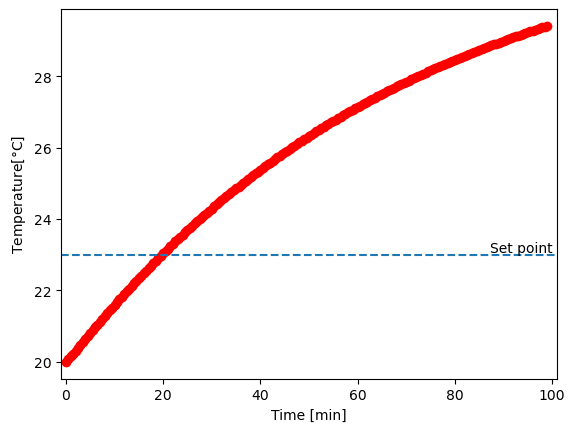

In [23]:
x, y = simulation(x_0=x_0, K=K, dt=dt,
                  u_OA=u_OA, u_qint=u_qint,
                  mode='free-float')

# Two-position action

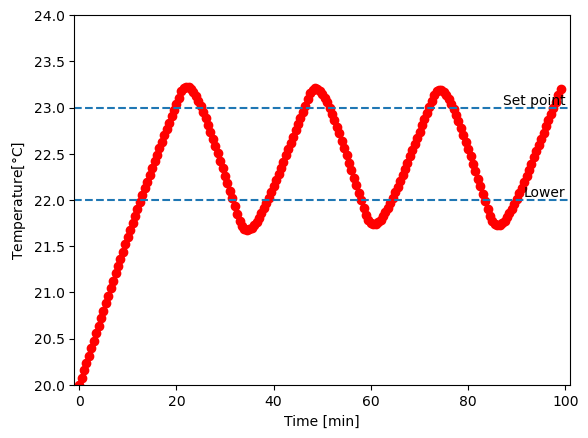

In [34]:
x, y = simulation(x_0=x_0, K=K, dt=dt,
                  u_OA=u_OA, u_qint=u_qint,
                  setpoint=23,
                  HVAC_cap=1000,
                  differential=1,
                  mode='two-position')

# PID control

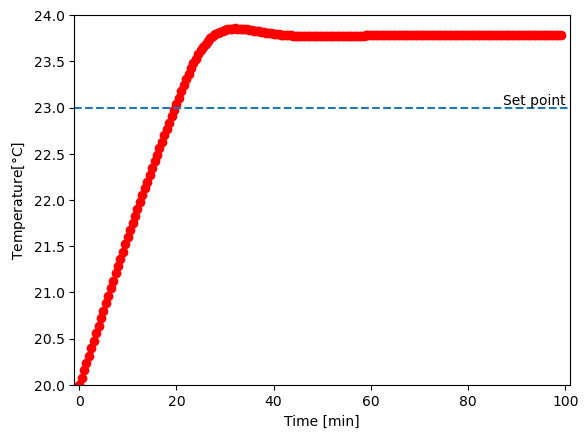

In [40]:
x, y = simulation(x_0=x_0, K=K, dt=dt,
                  u_OA=u_OA, u_qint=u_qint,
                  setpoint=23,
                  HVAC_cap=1000,
                  Kp=0.5, Ki=0, Kd=0,
                  mode='pid')